<a href="https://colab.research.google.com/github/vvjft/DL_BIQA/blob/main/CNNIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


### Download and extract dataset

In [10]:
!wget https://www.ponomarenko.info/tid2013/tid2013.rar # tid2013

from google.colab import drive
drive.mount('/content/drive') # LIVE

--2024-06-02 23:33:35--  https://www.ponomarenko.info/tid2013/tid2013.rar
Resolving www.ponomarenko.info (www.ponomarenko.info)... 154.41.250.142, 2a02:4780:1e:b41c:97b9:3fd3:ad38:82dc
Connecting to www.ponomarenko.info (www.ponomarenko.info)|154.41.250.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957680241 (913M) [application/x-rar-compressed]
Saving to: ‘tid2013.rar’

tid2013.rar         100%[===================>] 913.31M  78.5MB/s    in 12s     

2024-06-02 23:33:47 (75.7 MB/s) - ‘tid2013.rar’ saved [957680241/957680241]

Mounted at /content/drive


In [12]:
!mkdir -p '/content/tid2013'
!unrar x -inul '/content/tid2013.rar' '/content/tid2013'
!rm '/content/tid2013.rar'
!rm -r '/content/tid2013/metrics_values'
!rm -r '/content/tid2013/papers'
!rm '/content/tid2013/readme'
!rm -r '/content/sample_data'

!cp -r /content/drive/MyDrive/magisterka/LIVEIQA_release2 /content
os.rename('/content/LIVEIQA_release2', '/content/LIVE')
drive.flush_and_unmount()

rm: cannot remove '/content/tid2013.rar': No such file or directory
rm: cannot remove '/content/tid2013/metrics_values': No such file or directory
rm: cannot remove '/content/tid2013/papers': No such file or directory
rm: cannot remove '/content/tid2013/readme': No such file or directory
rm: cannot remove '/content/sample_data': No such file or directory


Reset directory if needed

In [ ]:
#!rm -r '/content/LIVE'
#!rm -r '/content/tid2013'
#!rm -r '/content/tid2013/patch_mos_with_names.csv'

rm: cannot remove '/content/tid2013': No such file or directory


##Preprocessing

#### Divide dataset

In [16]:
from sklearn.model_selection import train_test_split

def load_tid2013(base_dir):
    data_path = os.path.join(base_dir, 'mos_with_names.txt')
    data = pd.read_csv(data_path, header=None, delimiter=' ')
    data = data.iloc[:,[1,0]] # swamp colummns order
    distortion_types = [1, 8, 10, 11] # filter distortions: wn, blur, jpeg and jp2k
    filtered_data = data[data[1].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    filtered_data.columns = ['image_filename', 'MOS']
    return filtered_data

def load_live(base_dir):
    data = pd.read_csv(base_dir, 'dmos_with_names.csv')
    distortion_types = [1, 2, 3, 4] # filter distortions: wn, blur, jpeg and jp2k
    filtered_data = data[data[0].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    filtered_data.columns = ['image_filename', 'DMOS']
    return filtered_data

def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)
    return train_data, val_data, test_data

# Załaduj dane i podziel je
tid2013_dir = 'tid2013'
live_dir = 'LIVE'
db_dir = tid2013_dir
score_measure = 'DMOS' if db_dir == live_dir else 'MOS'

data = load_tid2013(tid2013_dir)
data.to_csv('tid2013/mos_with_names.csv', index=False)
#data = pd.read_csv('LIVE/dmos_with_names.csv')

train_data, val_data, test_data = split_data(data)

                 1        0
0     I01_01_1.bmp  5.51429
1     i01_01_2.bmp  5.56757
2     i01_01_3.bmp  4.94444
3     i01_01_4.bmp  4.37838
4     i01_01_5.bmp  3.86486
...            ...      ...
2995  i25_24_1.bmp  5.65714
2996  i25_24_2.bmp  5.44444
2997  i25_24_3.bmp  4.62857
2998  i25_24_4.bmp  4.02778
2999  i25_24_5.bmp  2.77143

[3000 rows x 2 columns]


#### Normalize and slice to patches

In [17]:
from scipy.signal import convolve2d
def liqd92_normalize(patch, P=3, Q=3, C=1):
    kernel = np.ones((P, Q)) / (P * Q)
    patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
    patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
    patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
    patch_ln = (patch - patch_mean) / patch_std
    return patch_ln.astype('float32')

sets = {'train': [train_data, 'training'], 'val':[val_data, 'validation'], 'test':[test_data, 'test']}
input_dir = f'{db_dir}/distorted_images/'

for key, (data, name) in sets.items():

  output_dir_full = f'{db_dir}/normalized_distorted_images/{name}/full/' # where to store normalized distorted images
  output_dir_patches = f'{db_dir}/normalized_distorted_images/{name}/patches/' # where to store patches
  norm_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/norm_{name}.csv'
  patch_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/patch_{name}.csv'
  os.makedirs(output_dir_full, exist_ok=True)
  os.makedirs(output_dir_patches, exist_ok=True)

  norm_info_list = []
  patch_info_list = []
  for index, row in data.iterrows():
      mos_value = row[1]
      image_filename = row[0]
      image_path = input_dir + image_filename
      image = cv2.imread(image_path)
      if image is None:
          print(f"Failed to load image: {image_filename}")
          continue
      # Normalize the image
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_normalized = liqd92_normalize(image_gray)
      #image_normalized = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)
      # Save
      image_filename = "NORM_"+image_filename
      norm_info_list.append([image_filename, mos_value])
      cv2.imwrite(output_dir_full+image_filename, image_normalized)
      # Slice to patches
      height, width = image_normalized.shape[:2]
      patch_size = 32
      num_patches_y = height // patch_size
      num_patches_x = width // patch_size
      patch_count = 0
      for i in range(num_patches_y):
          for j in range(num_patches_x):
              patch = image_normalized[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
              patch_path = os.path.join(output_dir_patches, f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp")
              patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp"
              cv2.imwrite(patch_path, patch)
              # Add patch info to the list
              patch_info_list.append([patch_filename, mos_value])
              patch_count += 1

  norm_info_df = pd.DataFrame(norm_info_list, columns=['image_filename', score_measure])
  norm_info_df.to_csv(norm_file_info_path, index=False)
  print(f"[{name}]: Saved full normalized distorted image info to:\n{patch_file_info_path}.")
  patch_info_df = pd.DataFrame(patch_info_list, columns=['image_filename', score_measure])
  patch_info_df.to_csv(patch_file_info_path, index=False)
  print(f"[{name}]: Saved patch info to {patch_file_info_path}.")


[training]: Saved full normalized distorted image info to:
tid2013/normalized_distorted_images/training/patch_training.csv.
[training]: Saved patch info to tid2013/normalized_distorted_images/training/patch_training.csv.
[validation]: Saved full normalized distorted image info to:
tid2013/normalized_distorted_images/validation/patch_validation.csv.
[validation]: Saved patch info to tid2013/normalized_distorted_images/validation/patch_validation.csv.
[test]: Saved full normalized distorted image info to:
tid2013/normalized_distorted_images/test/patch_test.csv.
[test]: Saved patch info to tid2013/normalized_distorted_images/test/patch_test.csv.


##### Validate the division

In [19]:
# Paths to the CSV files
norm_training_csv = f'{db_dir}/normalized_distorted_images/training/norm_training.csv'
norm_validation_csv = f'{db_dir}/normalized_distorted_images/validation/norm_validation.csv'
norm_test_csv = f'{db_dir}/normalized_distorted_images/test/norm_test.csv'

# Read the CSV files
norm_training_df = pd.read_csv(norm_training_csv)
norm_validation_df = pd.read_csv(norm_validation_csv)
norm_test_df = pd.read_csv(norm_test_csv)

# Extract the lists of filenames
training_files = set(norm_training_df['image_filename'])
validation_files = set(norm_validation_df['image_filename'])
test_files = set(norm_test_df['image_filename'])

# Check for common files
common_training_validation = training_files.intersection(validation_files)
common_training_test = training_files.intersection(test_files)
common_validation_test = validation_files.intersection(test_files)

# Print the results
if not common_training_validation and not common_training_test and not common_validation_test:
    print("There are no common files between norm_training, norm_validation, and norm_test.")
else:
    if common_training_validation:
        print(f"Common files between training and validation: {common_training_validation}")
    if common_training_test:
        print(f"Common files between training and test: {common_training_test}")
    if common_validation_test:
        print(f"Common files between validation and test: {common_validation_test}")


There are no common files between norm_training, norm_validation, and norm_test.


#### Load data into tensorflow data generators

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'training/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'validation/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True,
        seed=42
    )

    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'test/patches/'),
        x_col='image_filename',
        y_col=score_measure,
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

base_dir = f'{db_dir}/normalized_distorted_images'
train_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/training/patch_training.csv')
val_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/validation/patch_validation.csv')
test_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/patch_test.csv')
train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 57600 validated image filenames.
Found 19200 validated image filenames.
Found 19200 validated image filenames.


## Define and train the model

#### Network architecture

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(50, (7, 7), activation='relu', input_shape=(32, 32, 3)), # linear in the paper
        GlobalMaxPooling2D(),
        Dense(800, activation='relu'),
        #Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(800, activation='relu'),
        Dropout(0.5),  # Add dropout to prevent overfitting
        Dense(1, activation='linear')  # Output layer for the quality score
    ])
    return model

# Budowanie modelu
model = build_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 50)        7400      
                                                                 
 global_max_pooling2d (Glob  (None, 50)                0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 800)               40800     
                                                                 
 dense_1 (Dense)             (None, 800)               640800    
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 801       
                                                        

#### Training

In [22]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
1800/1800 [==============================] - 51s 28ms/step - loss: 1.6011 - mean_absolute_error: 0.9043 - val_loss: 1.0331 - val_mean_absolute_error: 0.7853
Epoch 2/10
1800/1800 [==============================] - 53s 29ms/step - loss: 0.8795 - mean_absolute_error: 0.7125 - val_loss: 0.9328 - val_mean_absolute_error: 0.7471
Epoch 3/10
1800/1800 [==============================] - 52s 29ms/step - loss: 0.8199 - mean_absolute_error: 0.6836 - val_loss: 0.9282 - val_mean_absolute_error: 0.7279
Epoch 4/10
1800/1800 [==============================] - 52s 29ms/step - loss: 0.7652 - mean_absolute_error: 0.6561 - val_loss: 0.8481 - val_mean_absolute_error: 0.6968
Epoch 5/10
1800/1800 [==============================] - 50s 28ms/step - loss: 0.7091 - mean_absolute_error: 0.6273 - val_loss: 0.8598 - val_mean_absolute_error: 0.6977
Epoch 6/10
1800/1800 [==============================] - 50s 28ms/step - loss: 0.6799 - mean_absolute_error: 0.6128 - val_loss: 0.8034 - val_mean_absolute_error:

## Summarize predictions

#### Predict test data and get labels (DMOS/MOS)

In [25]:
test_predictions = model.predict(test_generator)
patch_info = test_generator.filenames # get list of test patches
image_scores = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[1:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
    image_scores[base_image_name].append(test_predictions[i])

average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
average_scores_df = pd.DataFrame(list(average_scores.items()), columns=['Image', f'Predicted_{score_measure}'])
print("Summary of test predictions:")
print(average_scores_df.describe())

test_images_score = pd.read_csv(f'{db_dir}/{score_measure.lower()}_with_names.csv')
test_images_score.rename(columns={'image_filename':'Image', score_measure:score_measure}, inplace=True)
# Force all extensions to be '.bmp' (there are inconsitencies between mos_with_names.txt and actual filename: '.bmp' vs '.BMP')
test_images_score['Image'] = test_images_score['Image'].apply(lambda x: x.lower())
average_scores_df['Image'] = average_scores_df['Image'].apply(lambda x: x.lower())
# Merge dataframes to match predicted mos with ground-truth score
merged_df = average_scores_df.merge(test_images_score, on="Image", how="inner")
merged_df.rename(columns={f'Predicted_{score_measure}_x': f'Predicted_{score_measure}', f'Predicted_{score_measure}_y': {score_measure}}, inplace=True)
print(merged_df)

600/600 [==============================] - 10s 17ms/step
Summary of test predictions:
       Predicted_MOS
count     100.000000
mean        4.240536
std         0.932105
min         2.468772
25%         3.557366
50%         4.355707
75%         5.132157
max         5.487541
           Image  Predicted_MOS      MOS
0   i19_01_2.bmp       5.049118  5.10811
1   i04_10_4.bmp       3.588696  3.26190
2   i19_10_5.bmp       2.927089  1.65789
3   i08_11_1.bmp       5.168138  6.00000
4   i06_01_5.bmp       4.055730  3.61111
..           ...            ...      ...
95  i18_08_3.bmp       4.145979  4.14286
96  i05_08_2.bmp       5.025267  4.66667
97  i04_11_1.bmp       4.120670  5.30000
98  i22_11_4.bmp       2.904287  2.63158
99  i01_11_1.bmp       5.329905  5.91429

[100 rows x 3 columns]


#### Calculate correlations

In [26]:
from scipy.stats import spearmanr, pearsonr
# Drop NaN or inf values if present
cleaned_df = merged_df.dropna()
cleaned_df = cleaned_df[np.isfinite(cleaned_df[score_measure]) & np.isfinite(cleaned_df[f'Predicted_{score_measure}'])]

# Calculate LCC and SROCC
lcc = pearsonr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]
srocc = spearmanr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]

print(f"LCC (Linear Correlation Coefficient): {lcc}")
print(f"SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")

LCC (Linear Correlation Coefficient): 0.8743449731941076
SROCC (Spearman Rank Order Correlation Coefficient): 0.8649470895541166


#### Visualize correletions and training

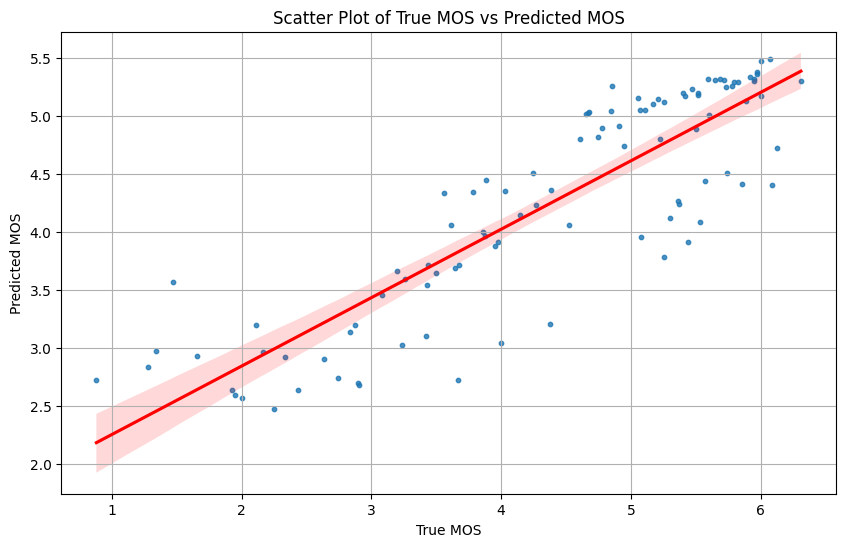

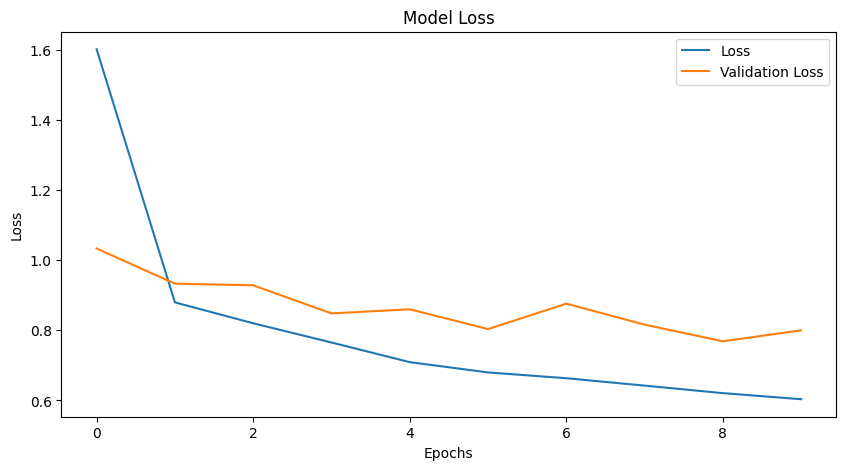

In [27]:
# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel(f'True {score_measure}')
plt.ylabel(f'Predicted {score_measure}')
plt.title(f'Scatter Plot of True {score_measure} vs Predicted {score_measure}')
plt.grid(True)
plt.show()

y_pred = test_predictions
y_true = test_generator.labels
# Training progress (loss minimization)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()